In [1]:
import pandas as pd
from scipy.special import iv
import numpy as np

def df_to_csv(df,filename):
    in_columns = ['event_no','azimuth_pred','zenith_pred']#,'azimuth_pred_sigma','zenith_pred_sigma']
    out_columns = ['event_no','azimuth_pred','zenith_pred','azimuth_sigma','zenith_sigma']
    
    R_az = iv(1,np.square(df.azimuth_pred_sigma))/iv(0,np.square(df.azimuth_pred_sigma))
    R_ze = iv(1,np.square(df.zenith_pred_sigma))/iv(0,np.square(df.zenith_pred_sigma))

    # az_sigma = np.sqrt(1 - R_az)
    # ze_sigma = np.sqrt(1 - R_ze)

    az_sigma = np.sqrt(-2*np.log(R_az))
    ze_sigma = np.sqrt(-2*np.log(R_ze))
    
    tmp = pd.DataFrame(pd.concat([df[in_columns],az_sigma,ze_sigma],1).values,columns=out_columns)
    tmp.to_csv('predictions/{}.csv'.format(filename))

# mc = pd.read_pickle('predictions/test_predictions.pkl')
# data = pd.read_pickle('predictions/test_data_predictions.pkl')

# df_to_csv(mc,'GGConv_1mio_MC_predictions01')
# df_to_csv(data,'GGConv_data_predictions01')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl

import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)
import os

In [2]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'oscNext_angle_m9'

args = {'N_edge_feats': 6,
        'N_dom_feats': 4,
        'N_targets': 2,
        'N_outputs': 4,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'twice_Polar_NLLH',
        'zenith': True,
        'id': wandb.util.generate_id()[:4],
        'eps': 0,
        'lr': 0.0209,
        'filename': 'dev_level7_mu_e_tau_oscweight_000_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith',
        'TrTV': (0.025,0.995,1)
       }

In [3]:
tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\transformers.pkl')
time_center, time_scale = tf['features']['time'].center_[0], tf['features']['time'].scale_[0]
charge_center, charge_scale = tf['features']['charge_log10'].center_[0], tf['features']['charge_log10'].scale_[0]
charge_center

-0.033858261664001306

In [3]:
centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300]})
centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

In [4]:
@torch.jit.script
def x_feature_constructor(x, graph_node_counts):
    tmp = []
    a : List[int] = graph_node_counts.tolist()
    for tmp_x in x.split(a):
        tmp_x = tmp_x.unsqueeze(1) - tmp_x

        cart = tmp_x[:,:,-3:]

        rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
        rho_mask = rho.squeeze() != 0
        if rho_mask.sum() != 0:
            cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
        tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)

        tmp.append(torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0]],dim=1))
    return torch.cat(tmp,0)

In [5]:
filepath = os.path.join(path,'raw_data/dev_level7_mu_e_tau_oscweight_000/data')
def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

# import dill
# with open('AzZe_Muon_bin_reweighter.pkl','rb') as file:
#     reweighter = dill.load(file)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
#                                event_nos = event_nos,
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = True,
#                                reweighter = reweighter
                               )

In [36]:
li = torch.nn.Linear(args['N_dom_feats']*2,5)
# norm = torch.nn.BatchNorm2d(5)
tmp_x = dataset[0].x.float()
tmp_x = torch.cat([tmp_x.unsqueeze(1) - tmp_x, tmp_x.unsqueeze(1) + tmp_x],dim=2)
tmp_x.shape, li(tmp_x).shape

(torch.Size([25, 25, 8]), torch.Size([25, 25, 5]))

In [43]:
tmp = []
for i in range(2):
    tmp_x = dataset[0].x.float()
    tmp.append(torch.cat([tmp_x.unsqueeze(1) - tmp_x, tmp_x.unsqueeze(1) + tmp_x],dim=2))
li(tmp)

AttributeError: 'list' object has no attribute 'dim'

In [13]:
train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=2)
for dat in train_loader:
    break
# import Model_Loaders.Model_13 as M

In [97]:
import torch_geometric
T = torch_geometric.nn.TransformerConv(in_channels = [4,4],
                                       out_channels = 1,
                                       heads = 4)

In [72]:
# def return_edge_index(batch):

edge_index = torch.cat([torch.zeros(dat.x.shape[0],dtype=torch.long).view(1,-1),
                        torch.arange(dat.x.shape[0],dtype=torch.long).view(1,-1)],dim=0)
edge_index = edge_index.flip(0).contiguous()
edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0]])

In [101]:
x_CoC[dat.batch.unique()]

tensor([[ 0.4254,  0.2978,  0.6247,  0.5012],
        [-0.5813, -1.1389, -1.3015,  0.7955]])

In [98]:
def return_edge_index(batch):
    offset = batch.max() + 1
    frm = torch.arange(offset, offset + batch.shape[0],dtype=torch.long).view(1,-1)
    to = batch.view(1,-1)
    return torch.cat([frm,to],dim=0).contiguous()

edge_index = return_edge_index(dat.batch)
CoC = torch.randn(2,4).float()
x_CoC = torch.cat([CoC,dat.x.float()],dim=0)

In [99]:
T(x_CoC,edge_index), T.lin_skip(dat.x.float())

(tensor([[-8.1741e-01,  2.0260e-01, -3.2949e-01,  8.7144e-02],
         [ 4.5862e-01, -3.3051e-01, -2.5118e-01,  7.8639e-01],
         [-1.0140e-01,  1.6002e-01, -4.3665e-01,  1.1924e-01],
         [ 4.3814e-02,  1.7031e-01, -4.2947e-01,  5.6311e-02],
         [ 8.5492e-02,  1.7097e-01, -4.3542e-01,  3.1548e-02],
         [ 1.5709e-01,  1.7060e-01, -4.5094e-01, -1.5432e-02],
         [ 1.8104e-01,  1.6870e-01, -4.6235e-01, -3.6355e-02],
         [-8.7739e-02,  1.4496e-01, -5.1044e-01,  9.1376e-02],
         [-8.2993e-02,  1.4123e-01, -5.2446e-01,  7.7388e-02],
         [-1.2892e-01,  1.6549e-01, -5.1061e-01,  5.4304e-02],
         [-2.6902e-01,  2.5011e-01, -4.9826e-01, -2.3644e-02],
         [-9.7558e-02,  2.0922e-01, -4.4288e-01,  4.0228e-02],
         [ 2.2945e-03,  2.0379e-01, -4.8176e-01, -3.9718e-02],
         [-1.1423e-03,  2.0329e-01, -4.8282e-01, -3.8973e-02],
         [ 6.4763e-03,  2.0218e-01, -4.8821e-01, -4.7104e-02],
         [-2.7711e-02,  1.9723e-01, -4.9875e-01, -3.969

In [71]:
T.lin_skip(dat.x.float()), T(dat.x.float(),edge_index)

(tensor([[ 0.1695],
         [ 0.0419],
         [ 0.0066],
         [-0.0532],
         [-0.0722],
         [ 0.2153],
         [ 0.2134],
         [ 0.1609],
         [ 0.0109],
         [ 0.0335],
         [-0.0471],
         [-0.0440],
         [-0.0497],
         [-0.0183],
         [-0.0625],
         [-0.0042],
         [-0.0478],
         [ 0.0735],
         [ 0.0521],
         [ 0.1491],
         [ 0.1383],
         [ 0.1230],
         [ 0.0911],
         [ 0.0927],
         [ 0.0951],
         [ 0.0831],
         [ 0.0850],
         [ 0.0866],
         [ 0.1131],
         [ 0.0803],
         [ 0.1116],
         [ 0.0686],
         [ 0.0618],
         [ 0.0387],
         [ 0.2628],
         [ 0.3576],
         [ 0.1827]], grad_fn=<AddmmBackward>),
 tensor([[0.5869],
         [0.4593],
         [0.4240],
         [0.3642],
         [0.3452],
         [0.6327],
         [0.6308],
         [0.5784],
         [0.4284],
         [0.4509],
         [0.3703],
         [0.3734],
     

In [67]:
dat.x,

(tensor([[ 9.6332e-02,  4.1657e-01, -4.3750e-01, -9.6433e-01],
         [-1.4153e-01,  4.1657e-01, -4.3750e-01, -1.0778e+00],
         [-1.9711e-01,  4.1657e-01, -4.3750e-01, -1.1345e+00],
         [-2.8418e-01,  4.1657e-01, -4.3750e-01, -1.2480e+00],
         [-3.0345e-01,  4.1657e-01, -4.3750e-01, -1.3047e+00],
         [-1.5561e-02,  1.0417e-01, -2.4310e-01, -9.7430e-01],
         [-7.4102e-04,  1.0417e-01, -2.4310e-01, -1.0210e+00],
         [ 5.8540e-02,  2.4123e-01, -2.2200e-01, -1.0467e+00],
         [ 4.0015e-02,  3.5647e-01,  9.0300e-02, -1.0031e+00],
         [-8.7810e-02,  3.7730e-01, -2.0157e-01, -9.8087e-01],
         [-1.8192e-01,  3.7730e-01, -2.0157e-01, -1.1911e+00],
         [-1.7488e-01,  3.7730e-01, -2.0157e-01, -1.1911e+00],
         [-1.7821e-01,  3.7730e-01, -2.0157e-01, -1.2145e+00],
         [-1.0819e-01,  3.7730e-01, -2.0157e-01, -1.2145e+00],
         [-1.7821e-01,  3.7730e-01, -2.0157e-01, -1.2846e+00],
         [-2.0007e-02,  3.7730e-01, -2.0157e-01, -1.354

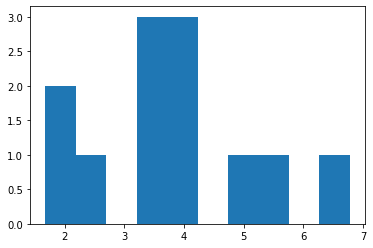

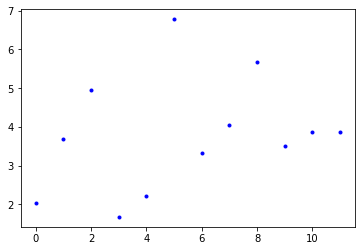

In [24]:
x = dat.x[dat.batch==0]

fig, ax = plt.subplots()
ax.hist(x[:,0]);

fig, ax = plt.subplots()
# ax.plot(x[:,0].cumsum(0));
ax.plot(x[:,0],'b.');

In [28]:
m1 = x[:,0].min()



# from torch_scatter import scatter_min
# scatter_min

tensor(1.6737, dtype=torch.float64)

In [55]:
def scatter_distribution(src, index):
    quantiles = torch.tensor([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    

[0, 1, 2, 3]

In [ ]:
def edge_feature_constructor(x, edge_index):
    (frm, to) = edge_index
    pos = x[:,2:5]
    cart = pos[frm] - pos[to]

    rho = torch.norm(cart, p=2, dim=-1).view(-1, 1)
    rho_mask = rho.squeeze() != 0
    cart[rho_mask] = cart[rho_mask] / rho[rho_mask]

    diff = x[to,

    return torch.cat([cart.type_as(pos),rho,diff.view(-1,1)], dim=1)

In [45]:
import torch_rbf as rbf

In [51]:
RBF = rbf.RBF(5,3,rbf.basis_func_dict()['gaussian'])
dat.x.shape
RBF(dat.x)

tensor([[4.0044e-07, 4.6944e-09, 1.4559e-11],
        [2.0413e-02, 8.7443e-04, 6.4163e-06],
        [1.0139e-05, 2.7420e-07, 1.5538e-09],
        [3.1429e-08, 2.4587e-10, 5.4322e-13],
        [1.2205e-04, 6.0389e-06, 9.6715e-08],
        [3.0459e-06, 5.2546e-08, 4.0009e-10],
        [3.3682e-07, 3.1174e-09, 1.5569e-11],
        [9.3522e-08, 6.3208e-10, 2.9889e-12],
        [1.4034e-08, 8.1904e-11, 6.6472e-14],
        [3.9707e-04, 2.1994e-05, 2.6428e-07],
        [6.6852e-03, 2.7228e-03, 1.0633e-04],
        [4.9143e-03, 2.3263e-04, 8.4992e-06],
        [4.3146e-10, 5.4526e-13, 9.1379e-16],
        [4.0079e-12, 1.0589e-14, 3.9780e-18],
        [8.2887e-09, 7.6167e-11, 1.0094e-13],
        [3.0781e-08, 3.0946e-10, 5.8683e-13],
        [2.5584e-03, 5.7336e-04, 2.2679e-05],
        [1.8160e-06, 7.6619e-09, 3.2777e-12],
        [1.1030e-02, 5.9272e-04, 5.4604e-06],
        [9.4618e-08, 1.4609e-10, 1.6261e-13],
        [7.3328e-05, 4.1299e-07, 1.8392e-09],
        [1.9388e-04, 3.0278e-06, 6

In [50]:
Net = M.Load_model(args['type'],args)
model = Net()
model.training_step(dat,0)

Remember all accuracies are positive and defined to go towards 0 in the optimal case.
This model assumes Charge is at index 0 and position is the last three


{'loss': tensor(0.0077, dtype=torch.float64, grad_fn=<DivBackward0>)}

In [6]:
# from torch_geometric.utils import softmax
import torch.nn.functional as F

In [13]:
data = dataset.collate(dataset[[i for i in range(512)]])
x, batch = data.x.float(), data.batch
graph_ids, graph_node_counts = batch.unique(return_counts=True)

In [14]:
data

Batch(batch=[12583], x=[12583, 5], y=[1024])

In [8]:
@torch.jit.script
def x_feature_constructor(x, graph_node_counts):
    tmp = []
    a : List[int] = graph_node_counts.tolist()
    for tmp_x in x.split(a):
        tmp_x = tmp_x.unsqueeze(1) - tmp_x

        cart = tmp_x[:,:,-3:]

        rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
        rho_mask = rho.squeeze() != 0
        if rho_mask.sum() != 0:
            cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
        tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)

        tmp.append(torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0]],dim=1))
    return torch.cat(tmp,0)
# x = torch.zeros((4,5))
# graph_node_counts = torch.tensor([2,2])

x_feature_constructor(x, graph_node_counts)

tensor([[-0.3294, -0.5722,  0.5779,  ...,  0.8071,  3.6475,  0.5587],
        [-0.4025, -0.7209, -0.2180,  ...,  0.7179,  2.9180,  0.3420],
        [-0.0862,  0.3444, -0.4567,  ...,  0.6913,  3.1004,  0.8470],
        ...,
        [-0.0094,  0.8598,  0.0098,  ...,  0.4343,  2.5533,  0.3268],
        [-0.7037, -0.2331,  0.1262,  ...,  0.4197,  2.1885,  0.0000],
        [-0.6462, -0.2209, -0.4449,  ...,  0.4343,  1.2766,  0.3735]])

In [57]:
def FC_edge_index(batch):
    graph_ids, graph_node_counts = batch.unique(return_counts=True)
    starts = torch.cumsum(torch.cat([torch.zeros(1,dtype=torch.long),graph_node_counts],dim=0),dim=0)
    
    edge_index = torch.cat([torch.combinations(torch.arange(start,start+length)) for start, length in zip(starts[:-1],graph_node_counts)],dim=0)
    return torch.cat([edge_index,edge_index.flip(1)]).T

edge_index = FC_edge_index(data.batch)
(edge_index == 0).sum()

tensor(38)

In [63]:
help(Data)

Help on class Data in module torch_geometric.data.data:

class Data(builtins.object)
 |  Data(x=None, edge_index=None, edge_attr=None, y=None, pos=None, normal=None, face=None, **kwargs)
 |  
 |  A plain old python object modeling a single graph with various
 |  (optional) attributes:
 |  
 |  Args:
 |      x (Tensor, optional): Node feature matrix with shape :obj:`[num_nodes,
 |          num_node_features]`. (default: :obj:`None`)
 |      edge_index (LongTensor, optional): Graph connectivity in COO format
 |          with shape :obj:`[2, num_edges]`. (default: :obj:`None`)
 |      edge_attr (Tensor, optional): Edge feature matrix with shape
 |          :obj:`[num_edges, num_edge_features]`. (default: :obj:`None`)
 |      y (Tensor, optional): Graph or node targets with arbitrary shape.
 |          (default: :obj:`None`)
 |      pos (Tensor, optional): Node position matrix with shape
 |          :obj:`[num_nodes, num_dimensions]`. (default: :obj:`None`)
 |      normal (Tensor, optional

In [67]:
data = dataset.collate(dataset[[0,1,2,3]])
graph_ids, graph_node_counts = data.batch.unique(return_counts=True)

from torch_geometric.data import Data
dataset.collate([Data(x=torch.randn(2,4),edge_index=torch.tensor([[0,1],[2,3]])),
                 Data(x=torch.randn(2,4),edge_index=torch.tensor([[0,1],[2,3]]))]).edge_index

tensor([[0, 1, 2, 3],
        [2, 3, 4, 5]])

In [8]:
act = torch.nn.SiLU()
            
class MLP(torch.nn.Module):
    def __init__(self, hcs_list, act = act):
        super(MLP, self).__init__()
        mlp = []
        for i in range(1,len(hcs_list)):
            mlp.append(torch.nn.Linear(hcs_list[i-1], hcs_list[i]))
            mlp.append(torch.nn.BatchNorm1d(hcs_list[i]))
            mlp.append(act)

        self.mlp = torch.nn.Sequential(*mlp)
    def forward(self, x):
        return self.mlp(x)

class AttGNN(torch.nn.Module):
    def __init__(self, hcs_in, hcs_out, act = act):
        super(AttGNN, self).__init__()

        self.beta = torch.nn.Parameter(torch.ones(1)*20)

        self.self_mlp = MLP([hcs_in,hcs_in,hcs_out])
        self.msg_mlp = MLP([hcs_in,hcs_in,hcs_out])
#     @torch.jit.script_method
    def forward(self, x, graph_node_counts):
        
        li : List[int] = graph_node_counts.tolist()
        
        tmp = []
        for tmp_x, msg in zip(x.split(li), self.msg_mlp(x).split(li)):
            att = F.normalize(tmp_x,p=2.,dim=1)
            att = torch.cdist(att,att)
#             att = F.softmax(self.beta*att,1)
            return att, msg
#             att[att < att.mean()] = 0
#             tmp.append(torch.matmul(att,msg))
#         return self.self_mlp(x) + torch.cat(tmp,0)
    
#         att = []
#         for tmp_x in x.split(li):
#             tmp_x = F.normalize(tmp_x,p=2,dim=1)
#             tmp_x = torch.cdist(tmp_x,tmp_x)
#             att.append(F.softmax(self.beta*tmp_x,1))
#         return self.self_mlp(x) + torch.matmul(torch.block_diag(*att), self.msg_mlp(x))
        
class Att2GNN(torch.nn.Module):
    def __init__(self, hcs_in, hcs_out, act = act):
        super(Att2GNN, self).__init__()

        self.beta = torch.nn.Parameter(torch.ones(1)*20)
        
        self.att_mlp = torch.nn.Sequential(torch.nn.Linear(2*hcs_in,hcs_in),
                                        act,
                                        torch.nn.Linear(hcs_in,1))

        self.self_mlp = MLP([hcs_in,hcs_in,hcs_out])
        self.msg_mlp = MLP([hcs_in,hcs_in,hcs_out])

    def forward(self, x, graph_node_counts):
        
        li : List[int] = graph_node_counts.tolist()
        
        tmp = []
        for tmp_x, msg in zip(x.split(li), self.msg_mlp(x).split(li)):
            tmp_x = torch.cat([tmp_x.unsqueeze(1) - tmp_x, tmp_x.unsqueeze(1) + tmp_x],dim=2)
            tmp_x = self.att_mlp(tmp_x).squeeze()
            tmp.append(torch.matmul(tmp_x,msg))
            return tmp_x

In [17]:
# lin = MLP([5,10,1])
lin(x), x, lin(x)*x, 0.9086*-0.0534

(tensor([[ 0.9086],
         [ 0.7317],
         [ 0.4734],
         ...,
         [ 0.3494],
         [-0.2203],
         [ 0.8397]], grad_fn=<SiluBackward>),
 tensor([[ 3.8622, -0.0534,  0.0057, -0.5021, -1.4062],
         [ 4.4093, -0.2408, -0.2593, -0.1811, -1.2178],
         [ 5.6860, -0.1178,  0.1387,  0.1183, -1.1571],
         ...,
         [ 1.6737, -0.1401, -0.0323, -0.2650, -1.5259],
         [ 2.0385, -0.3309, -0.0366,  0.0224, -1.0139],
         [ 3.4975,  0.0430, -0.0366,  0.0224, -1.5045]]),
 tensor([[ 3.5092, -0.0485,  0.0052, -0.4562, -1.2777],
         [ 3.2265, -0.1762, -0.1898, -0.1325, -0.8911],
         [ 2.6917, -0.0558,  0.0656,  0.0560, -0.5478],
         ...,
         [ 0.5848, -0.0489, -0.0113, -0.0926, -0.5332],
         [-0.4491,  0.0729,  0.0081, -0.0049,  0.2234],
         [ 2.9369,  0.0361, -0.0307,  0.0188, -1.2634]], grad_fn=<MulBackward0>),
 -0.04851924)

In [40]:
scripted = torch.jit.script(AttGNN(5,64))
att = scripted(x,graph_node_counts)

AttributeError: 'tuple' object has no attribute 'shape'

In [65]:
scripted = AttGNN(5,5)
att, msg = scripted(x,graph_node_counts)
(att > att.mean(1)).sum(1)

tensor([17,  6, 12,  6, 26,  8,  0,  8, 21, 13, 15, 21,  7,  2,  7, 13, 17, 28,
        24, 12, 14, 31,  5, 19, 33,  2, 19,  5, 16,  9, 12, 12, 15,  3, 24])

In [50]:
A = AttGNN(5,64)
A(x,graph_node_counts)

(tensor([[0.0000, 0.1455, 0.1689,  ..., 0.2689, 0.2168, 0.3944],
         [0.1455, 0.0000, 0.1525,  ..., 0.1300, 0.1372, 0.2670],
         [0.1689, 0.1525, 0.0000,  ..., 0.2151, 0.1194, 0.2954],
         ...,
         [0.2689, 0.1300, 0.2151,  ..., 0.0005, 0.1307, 0.1446],
         [0.2168, 0.1372, 0.1194,  ..., 0.1307, 0.0000, 0.1981],
         [0.3944, 0.2670, 0.2954,  ..., 0.1446, 0.1981, 0.0000]]),
 tensor([[-0.0576,  0.1459,  0.1877,  ...,  0.0825,  0.0890, -0.1053],
         [-0.0747,  0.0842,  0.2075,  ...,  0.1453,  0.0875, -0.0242],
         [-0.0798,  0.1647,  0.1707,  ...,  0.1470,  0.0782, -0.0853],
         ...,
         [ 0.0334,  0.0819, -0.0069,  ..., -0.0060, -0.0297,  0.0883],
         [ 0.0591,  0.1543, -0.0432,  ..., -0.0497, -0.0600,  0.0146],
         [ 0.1472,  0.0896, -0.1432,  ..., -0.1089, -0.1255,  0.1904]],
        grad_fn=<SplitWithSizesBackward>))

In [170]:
torch.gather(x,-1,batch)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [36]:


def forward(x, graph_node_counts):
    att = []
    for tmp_x in x.split(graph_node_counts.tolist()):
        tmp_x = F.normalize(tmp_x,p=2,dim=1)
        tmp_x = torch.cdist(tmp_x,tmp_x)
        att.append(F.softmax(tmp_x,1))
    return torch.matmul(torch.block_diag(*att),x)
graph_ids, graph_node_counts = batch.unique(return_counts=True)
att = forward(x, graph_node_counts)
att

tensor([[ 3.4501, -0.1086,  0.0457, -0.1864, -0.8372],
        [ 3.3598, -0.1090,  0.0415, -0.1881, -0.8418],
        [ 3.4428, -0.0911,  0.0536, -0.1820, -0.8401],
        ...,
        [ 3.4325, -0.1633,  0.0290, -0.1883, -1.4630],
        [ 3.4530, -0.1633,  0.0293, -0.1890, -1.4628],
        [ 3.5029, -0.1677,  0.0280, -0.1965, -1.4586]], dtype=torch.float64)

In [30]:
torch.bmm(x.split(graph_node_counts.tolist()),x.split(graph_node_counts.tolist()))

TypeError: bmm(): argument 'input' (position 1) must be Tensor, not tuple

In [32]:
F.pad

<function torch.nn.functional._pad(input, pad, mode='constant', value=0)>

In [77]:
tmp_x = dataset[0].x
tmp_x = F.normalize(tmp_x,p=2,dim=1)
tmp_x = torch.cdist(tmp_x,tmp_x)
tmp_x = F.softmax(tmp_x,1)
tmp_x
# tmp_x = tmp_x.unsqueeze(1) - 0*tmp_x
# tmp_x

# tmp_x = F.normalize(tmp_x, p=2, dim=2)

# torch.matmul(tmp_x.unsqueeze(2),tmp_x.unsqueeze(3)).squeeze()

tensor([[0.0222, 0.0444, 0.0488,  ..., 0.0236, 0.0357, 0.0363],
        [0.0368, 0.0184, 0.0205,  ..., 0.0357, 0.0249, 0.0246],
        [0.0372, 0.0188, 0.0169,  ..., 0.0360, 0.0249, 0.0246],
        ...,
        [0.0245, 0.0447, 0.0491,  ..., 0.0230, 0.0354, 0.0360],
        [0.0359, 0.0302, 0.0329,  ..., 0.0343, 0.0223, 0.0227],
        [0.0361, 0.0295, 0.0321,  ..., 0.0344, 0.0224, 0.0221]],
       dtype=torch.float64)